# Стеганография

In [1]:
import numpy as np

MAX_LENGTH = 2**16 - 1

def align(s, i=8):
    return s if len(s) == i else align('0' + s, i)

def calcFreeBits(img_size, key):
    w, h = img_size
    r_bit, g_bit, b_bit = key
    return (r_bit + g_bit + b_bit) * w * h
    

def calcMaxBytes(img_size, key):
    w, h = img_size
    r_bit, g_bit, b_bit = key
    return (r_bit + g_bit + b_bit) * w * h // 8


def encode(img_data, byte_data, key):
    clr_map = np.copy(img_data).ravel()
    clr_map.setflags(write = True)
    
    len_data = len(byte_data)
    
    # ключ к расшифровке - макс число 888 (для rgba - 8888)
    len_key = len(key)
    digit_key = int("".join(list(map(str, key))))
      
    # разбите на биты длины данных и ключа
    head_bits = []
    head_shift = 2                 
    bit_mask = 2**head_shift - 1   #00000011
    for byte in [len_data // 256, len_data % 256, digit_key // 256, digit_key % 256]:
        for i in range(8, 0, -head_shift):
            head_bits.append((byte >> i - head_shift) & bit_mask)
    
    # записть длины данных и ключа
    # маска для зануления
    head_mask = 2**8 - 2**2        #11111100
    len_head_bits = len(head_bits) # == 16
    for i in range(len_head_bits):
        clr_map[i] = clr_map[i] & head_mask | head_bits[i]
    
    i_byte = 0
    byte_shift = 0
    i_key = 0
    i_clr = 16
    while i_byte < len_data:
        bit = ((byte_data[i_byte] << byte_shift) % 256) >> (8 - key[i_key])
        mask = 2**8 - 2**key[i_key]
        if (8 - byte_shift) < key[i_key] and (i_byte + 1) < len_data:
            bit = ((byte_data[i_byte] << byte_shift) % 256) >> (8 - key[i_key])
            useless_bit = key[i_key] - (8 - byte_shift)
            i_byte += 1
            bit_end = byte_data[i_byte] >> 8 - useless_bit
            bit = bit | bit_end
            byte_shift = useless_bit
            clr_map[i_clr] = clr_map[i_clr] & mask | bit
            i_key = (i_key + 1) % len_key
            i_clr += 1
        else:
            clr_map[i_clr] = clr_map[i_clr] & mask | bit
            byte_shift += key[i_key]
            i_key = (i_key + 1) % len_key
            i_clr += 1
            if byte_shift >= 8:
                byte_shift %= 8
                i_byte += 1
    return clr_map.reshape(img_data.shape)


def decode(img_data):
    clr_map = np.copy(img_data).ravel()
    clr_map.setflags(write = True)
       
    # собирание байт заголовка
    head_shift = 2                 #111111XX
    head_mask = 2**head_shift - 1  #00000011
    head_bytes = []
    for i in range(0, 16, 4): 
        byte = 0
        byte = byte | (clr_map[i] & head_mask) << 6
        byte = byte | (clr_map[i+1] & head_mask) << 4
        byte = byte | (clr_map[i+2] & head_mask) << 2
        byte = byte | (clr_map[i+3] & head_mask) << 0
        head_bytes.append(byte)
    
    len_data = head_bytes[0]*256 + head_bytes[1]
    digit_key = head_bytes[2]*256 + head_bytes[3]
    key = list(map(int, str(digit_key)))
    len_key = len(key)
    
    bits = []
    i_byte = 0
    byte_shift = 0
    i_key = 0
    i_clr = 16
    while i_byte < len_data:
        bit = clr_map[i_clr] & (2**key[i_key]-1)        
        bit = align(bin(bit)[2:], key[i_key])
        bits.append(bit)
        byte_shift += key[i_key]
        i_key = (i_key + 1) % len_key
        i_clr += 1
        if byte_shift >= 8:
            byte_shift %= 8
            i_byte += 1
    
    byte_tmp = "".join(bits)
    byte_tmp = [byte_tmp[i:i+8] for i in range(0,len(byte_tmp), 8)]
    if len(byte_tmp[-1]) < 8:
        byte_tmp.pop()
      
    byte_data = list(map(lambda x: int(x, 2), byte_tmp))   
    return byte_data

## Использование
### Входные данные

In [2]:
# Число бит на каждую компоненту
key = 1, 2, 4

# Изображение для записи
img_source = "24bit_2s.bmp"

# Результат работы алгоритма
img_encode = "encode.bmp"

# Текст для скрытия в кодировке utf-8
text_utf8_path = "text.txt"

# png изображения
img_png_s = "s.png"
img_png_e = "e.png"

### Загрузка

In [3]:
from PIL import Image
# Загрузка изображения
image = Image.open(img_source)

# размер картинки
img_size = image.size

# массив пикселей картинки
img_clr_map = np.asarray(image, dtype=np.uint8)

In [4]:
# Загрузка текста
sourse_text = ""

with open(text_utf8_path, encoding="utf-8") as file: 
    sourse_text = file.read()

# кодирование текста в utf-8 байты
byte_text = sourse_text.encode("utf-8")

len_data = len(byte_text)
if len_data > MAX_LENGTH:
    print(f"Алгоритм не поддерживает такое колличество байт. Максимально доступно {MAX_LENGTH}. Длина текста {len_data} байт.")
else:
    max_bytes = calcMaxBytes(img_size, key)
    if max_bytes < len_data:
        print(f"Не хватает места для записи в картинку. Доступно {max_bytes} байт. Длина текста {len_data} байт.")
    else:
        print(f"Все ОК. Длина текста {len_data} байт.")

Все ОК. Длина текста 54083 байт.


### "Шифрование"

In [5]:
encode_clr_map = encode(img_clr_map, byte_text, key)

# Сохранение в картинку
Image.fromarray(encode_clr_map).save(img_encode)

### "Расшифровывание"

In [6]:
# Загрузка изображения
image = Image.open(img_encode)
img_clr_map = np.asarray(image, dtype=np.uint8)

decode_bytes = decode(img_clr_map)

### Результат

In [7]:
from IPython.display import Image as IPImage

Image.open(img_source).save(img_png_s)
Image.open(img_encode).save(img_png_e)

#### Исходное изображение

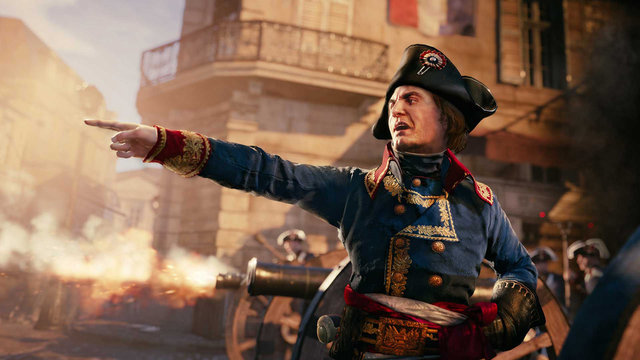

In [8]:
IPImage(img_png_s)

#### Изображение с информацией

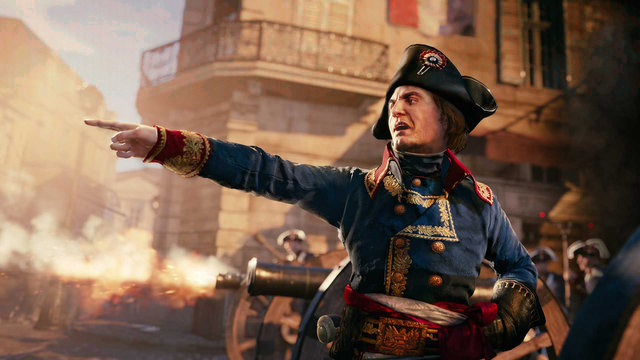

In [9]:
IPImage(img_png_e)

#### Текст

In [10]:
import struct

# print(decode_bytes)

pack = struct.pack("B"*len(decode_bytes), *decode_bytes)
# print(pack)

decode_text = pack.decode("utf-8")

with open("res_text.txt", mode="w", encoding="utf-8") as file:
    file.write(decode_text)
    
# print(decode_text)

## Тест

In [11]:
# https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [ ]:
import random
import itertools
import numpy
from PIL import Image

image = Image.open("24bit_2s.bmp")
img_clr_map = np.asarray(image, dtype=np.uint8)

list_list = [[random.randint(0, 255) for _ in range(random.randint(0, 100))] for _ in range(50)]

for list_ in log_progress(list_list):
    for key in list(itertools.product((1, 2, 3, 4, 5, 6, 7, 8), repeat=3)):
            encode_clr_map = encode(img_clr_map, list_, key)
            decode_bytes = decode(encode_clr_map)            
            if not numpy.array_equal(decode_bytes, list_):
                print("k", key)
                print("s", list_)
                print("r", decode_bytes)